In [1]:
from fenics import *
import numpy as np
import matplotlib.pyplot as plt
fid = File("heat2/solution.pvd")

In [2]:
T = 10.0 # final time
num_steps = 10 # number of time steps
dt = T / num_steps # time step size
alpha = 3 # parameter alpha
beta = 1.2 # parameter beta

In [3]:
# Create mesh and define function space
nx = ny = 8
mesh = UnitSquareMesh(nx, ny)
V = FunctionSpace(mesh, 'Lagrange', 1)
# Define boundary condition
u_D = Expression('1 + x[0]*x[0] + alpha*x[1]*x[1] + beta*t',degree=2, alpha=alpha, beta=beta, t=0)

In [4]:
def boundary(x, on_boundary):
    return on_boundary
bc = DirichletBC(V, u_D, boundary)

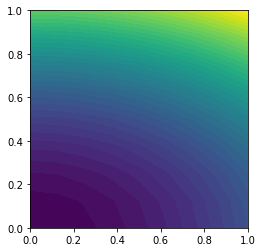

In [5]:
# Define initial value
u_n = interpolate(u_D, V)
plot(u_n)
plt.show()
#u_n = project(u_D, V)

Recordemos que por Teorema de Green:
$$ - \int_{\Omega}  \Delta u v \, dx = \int_{\Omega} \nabla u \nabla v \, dx - \int_{\partial \Omega} \frac{\partial u}{\partial \eta} v \, dS $$

El problema variacional esta dado por:
$$ \int_{\Omega} \Big( u^kv + dt(\nabla u^k \cdot \nabla v) \Big)\, dx =  \int_{\Omega} (u^{k-1} + dt f) v \, dx$$
con $f = \beta - 2 - 2 \alpha$. Por lo tanto:
$$ \int_{\Omega} \Big( u^kv  - (u^{k-1} + dt f) v \Big) \, dx = - \int_{\Omega} dt(\nabla u^k \cdot \nabla v) \, dx$$
$$ \int_{\Omega} v ( u^k  - u^{k-1} - dt f ) \, dx = - \int_{\Omega}  \Delta u v \, dx$$

De donde, 
$$u^{k-1} = u^k - dt f$$
$$\frac{u^k - u^{k-1}}{dt} = f$$
Pero 
$$ \frac{\partial u^k}{\partial t} \approx \frac{u^k - u^{k-1}}{dt}$$
Entonces:
$$ \int_{\Omega} \frac{\partial u}{\partial t} v \, dx = \int_{\Omega} f v \, dx - \int_{\Omega}  \Delta u v \, dx$$
Y el problema esta dado por:
$$ \frac{\partial u}{\partial t} = -\Delta u + f$$
$$u = u_0 \text{ on } \partial \Omega,$$

In [6]:
# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(beta - 2 - 2*alpha)
a = u*v*dx + dt*inner(nabla_grad(u), nabla_grad(v))*dx
L = (u_n + dt*f)*v*dx
#Other way to set the variational problem in Fenics, lhs and rhs detect the bilinear and linear form in F
#F = u*v*dx + dt*inner(nabla_grad(u), nabla_grad(v))*dx + (u_n + dt*f)*v*dx
#a, L = lhs(F), rhs(F)
# Time-stepping
u = Function(V)
t = 0

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
t = 1.00: error = 2.22e-15
Solving linear variational problem.
t = 2.00: error = 2.66e-15
Solving linear variational problem.
t = 3.00: error = 2.66e-15
Solving linear variational problem.
t = 4.00: error = 3.55e-15
Solving linear variational problem.
t = 5.00: error = 5.33e-15
Solving linear variational problem.
t = 6.00: error = 7.11e-15
Solving linear variational problem.
t = 7.00: error = 7.11e-15
Solving linear variational problem.
t = 8.00: error = 7.11e-15
Solving linear variational problem.
t = 9.00: error = 7.11e-15
Solving linear variational problem.
t = 10.00: error = 7.11e-15


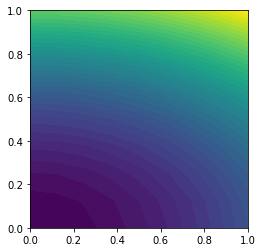

In [7]:
for n in range(num_steps):
    # Update current time
    t += dt
    u_D.t = t
    # Compute solution
    solve(a == L, u, bc)
    # Plot solution
    plot(u)
    # Compute error at vertices
    u_e = interpolate(u_D, V)
    error = np.abs(u_e.vector().get_local() - u.vector().get_local()).max()
    print('t = %.2f: error = %.3g' % (t, error))
    # Update previous solution
    u_n.assign(u)
    u.rename("u", "u") #see the QA reported below.
    fid << u, t

# Hold plot
plt.show()